Data
Info about this data set: https://fred.stlouisfed.org/series/IPN31152N

Units: Index 2012=100, Not Seasonally Adjusted

Frequency: Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation: Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

Project Tasks
TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [40]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [42]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [43]:
df.columns = ['Production']

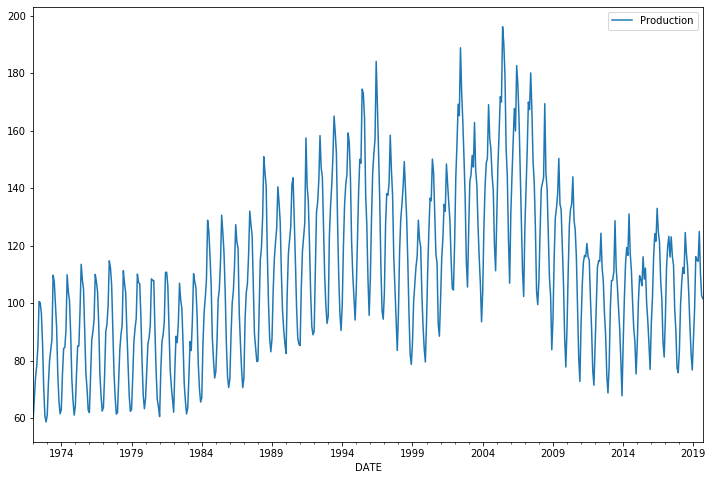

In [44]:
df.plot(figsize=(12,8))

In [45]:
len(df)

573

In [46]:
test_size = 18
test_ind = len(df) - test_size

In [47]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [48]:
len(test)

18

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
scaler = MinMaxScaler()

In [51]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
scaled_train = scaler.transform(train)

In [53]:
scaled_test = scaler.transform(test)

In [54]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [55]:
length = 12
n_features =1
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [57]:
model = Sequential()
model.add(LSTM(150,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [59]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [62]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
543/543 [==============================] - 15s 28ms/step - loss: 0.0184 - val_loss: 0.0014
Epoch 2/20
543/543 [==============================] - 14s 26ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 3/20
543/543 [==============================] - 14s 26ms/step - loss: 0.0040 - val_loss: 0.0021


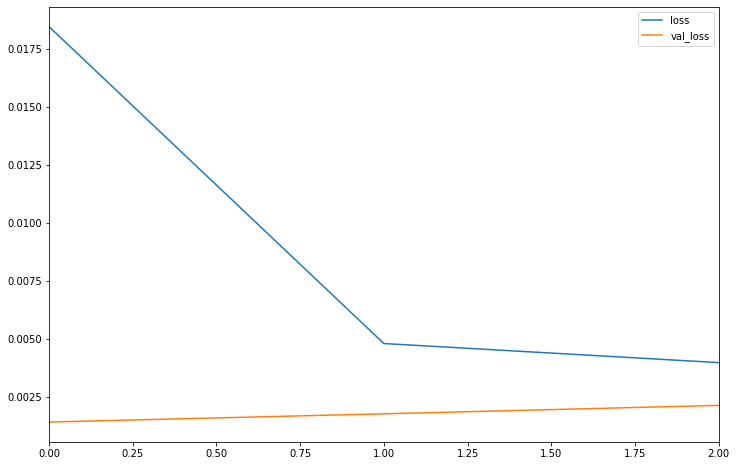

In [63]:
loss = pd.DataFrame(model.history.history)
loss.plot(figsize=(12,8))

In [64]:
import numpy as np

test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [65]:
# test_predictions

In [66]:
true_predictions = scaler.inverse_transform(test_predictions)

In [67]:
test['Predictions'] = true_predictions

c:\users\esaeri-1122\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,114.001273
2018-05-01,110.3544,119.997177
2018-06-01,124.5841,123.409829
2018-07-01,117.2215,121.449193
2018-08-01,112.6779,114.678227
2018-09-01,103.3118,103.527364
2018-10-01,92.1321,92.342305
2018-11-01,82.4347,84.117892
2018-12-01,76.7608,82.276871


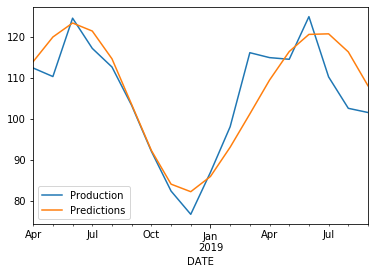

In [69]:
test.plot()

In [70]:
# Calc RMSE
from sklearn.metrics import mean_squared_error

In [71]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

6.647617288934655

In [ ]:
# RMSE = 6.6... Not bad!